In [6]:
# Import Required Libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from tqdm import tqdm

import os
import sys
import time
import math
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.init as init
from torch.autograd import Variable

from scipy.ndimage import rotate
from pretrained_models.resnet20 import ResNetCIFAR

from functions import *
from importlib import reload

reload(sys.modules["functions"])

<module 'functions' from '/workspaces/Adversarial-Patches-Experimentation/10_code/functions.py'>

## Prepare Data

In [7]:
# PARAMS
batch_size = 256
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# target = 1  # automobile

# CIFAR-10 image tensor mean and std
NORM_MEAN = [0.4914, 0.4822, 0.4465]
NORM_STD = [0.2023, 0.1994, 0.2010]

# TODO: should we apply the below transformations?
transform_train = transforms.Compose(
    [
        # transforms.RandomCrop(32, padding=4),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=NORM_MEAN, std=NORM_STD),
    ]
)

transform_test = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(mean=NORM_MEAN, std=NORM_STD)]
)

transform_image = transforms.ToPILImage()

print("==> Preparing data..")
trainset = torchvision.datasets.CIFAR10(
    root="../00_data", train=True, download=True, transform=transform_train
)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=4
)

testset = torchvision.datasets.CIFAR10(
    root="../00_data", train=False, download=True, transform=transform_test
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2
)

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


In [8]:
# Train-Validation Split
train_set, val_set = torch.utils.data.random_split(trainset, [0.8, 0.2])
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=4
)
val_loader = torch.utils.data.DataLoader(
    val_set, batch_size=32, shuffle=False, drop_last=False, num_workers=4
)

# Untargeted Attack

### Square Patch - Train & Generation

In [9]:
p_16_u, r_16_u = generate_patch(patch_size = 16, patch_type = 'square', targeted = False, train_loader = train_loader, val_loader = val_loader, device = 'cuda', num_epochs = 10)

write_to_json(p_16_u, r_16_u, 16, 'Untargeted', target = None)

  0%|          | 0/156 [00:00<?, ?it/s]/workspaces/Adversarial-Patches-Experimentation/10_code/pretrained_models/FP_layers.py:134: UserWarning: Attempt to open cnn_infer failed: handle=0 error: libcudnn_cnn_infer.so.8: cannot open shared object file: No such file or directory (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:78.)
  return F.conv2d(


Epoch 0, Attack Success Rate: 0.7201499938964844.


Epoch 5, Attack Success Rate: 0.8980000019073486.


Epoch 9, Attack Success Rate: 0.8980000019073486.


TypeError: Object of type Tensor is not JSON serializable

In [7]:
p_7_u, r_7_u = generate_patch(patch_size = 7, patch_type = 'square', targeted = False, train_loader = train_loader, val_loader = val_loader, device = 'cuda', num_epochs = 10)

write_to_json(p_7_u, r_7_u, 7, 'Untargeted', target = None)

Epoch 0, Attack Success Rate: 0.3500500023365021.


Epoch 5, Attack Success Rate: 0.6795499920845032.


Epoch 9, Attack Success Rate: 0.6822249889373779.


In [8]:
p_5_u, r_5_u = generate_patch(patch_size = 5, patch_type = 'square', targeted = False, train_loader = train_loader, val_loader = val_loader, device = 'cuda', num_epochs = 10)

write_to_json(p_5_u, r_5_u, 5, 'Untargeted', target = None)

Epoch 0, Attack Success Rate: 0.24232499301433563.


Epoch 5, Attack Success Rate: 0.5465750098228455.


Epoch 9, Attack Success Rate: 0.5608749985694885.


In [9]:
p_3_u, r_3_u = generate_patch(patch_size = 3, patch_type = 'square', targeted = False, train_loader = train_loader, val_loader = val_loader, device = 'cuda', num_epochs = 10)

write_to_json(p_3_u, r_3_u, 3, 'Untargeted', target = None)

Epoch 0, Attack Success Rate: 0.13392499089241028.


Epoch 5, Attack Success Rate: 0.2854749858379364.


Epoch 9, Attack Success Rate: 0.2955249845981598.


### Evaluation & Results Generation

In [35]:
# collecting results
patch_size = ['3 x 3', '5 x 5', '7 x 7', '16 x 16']
classes = ('Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck')
patches = [p_3_u, p_5_u, p_7_u, p_16_u]
results = [r_3_u, r_5_u, r_7_u, r_16_u]

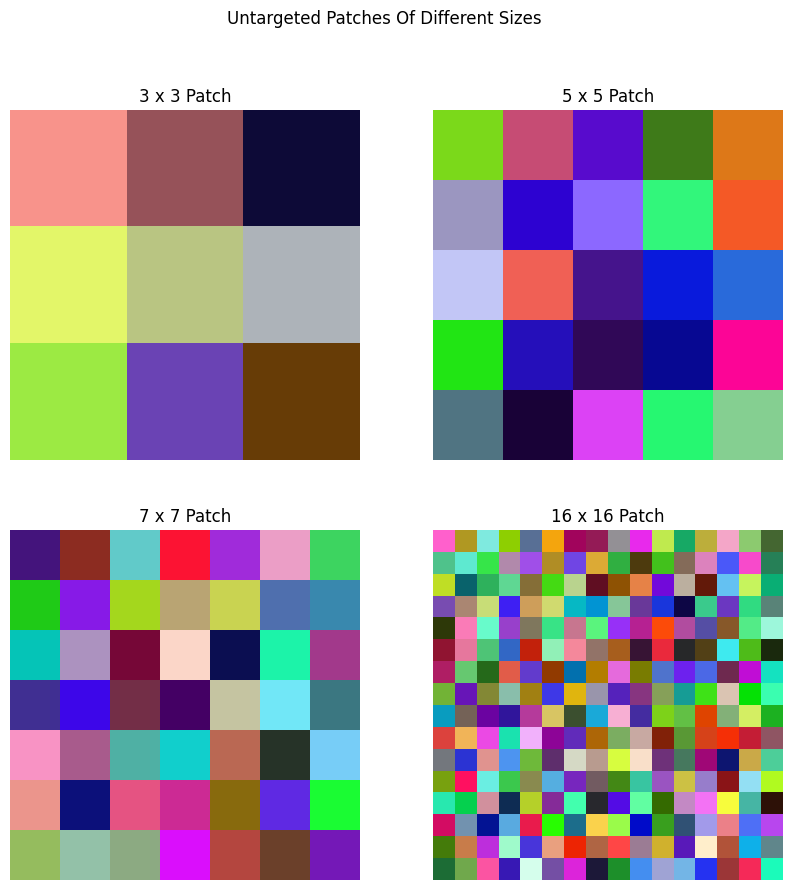

In [50]:
# visualizing each patch
plt.figure(figsize=(10, 10))

for i in range(len(patch_size)):
    plt.subplot(2, 2, i + 1)
    image = transform_image(patches[i])
    plt.imshow(image)
    plt.title(patch_size[i] + " Patch")
    plt.axis("off")

plt.suptitle(f"Untargeted Patches Of Different Sizes")

plt.savefig(f"../20_output_files/untargeted_patches.png")

Validating...:   0%|          | 1/313 [00:00<00:48,  6.38it/s]

Test Loss=0.0343, Test accuracy=0.9886


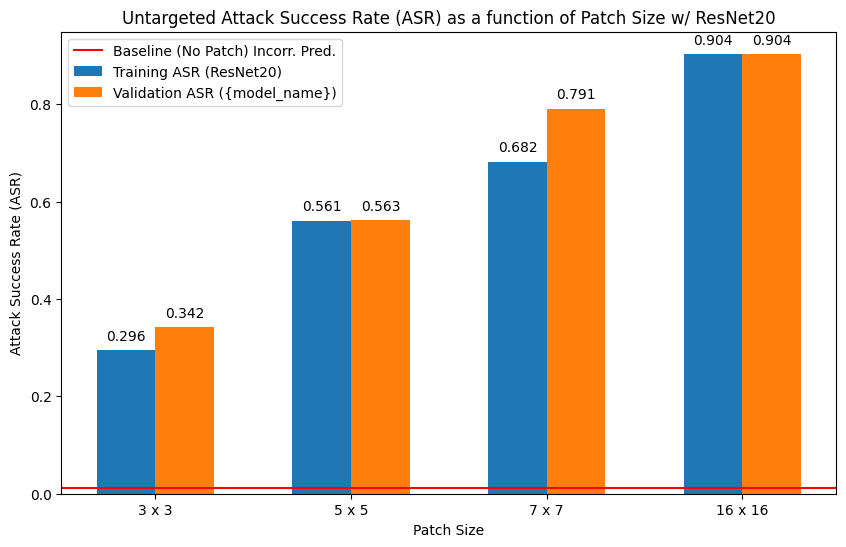

In [64]:
# plot the ASR as a function of the patch size

plot_asr(patches, results, val_loader, patch_size, attack_type = 'Untargeted', shape = 'square', model_name='ResNet20')

### Transferability - VGG

Using cache found in /home/codespace/.cache/torch/hub/pytorch_vision_v0.10.0


Test Loss=0.0127, Test accuracy=0.9992


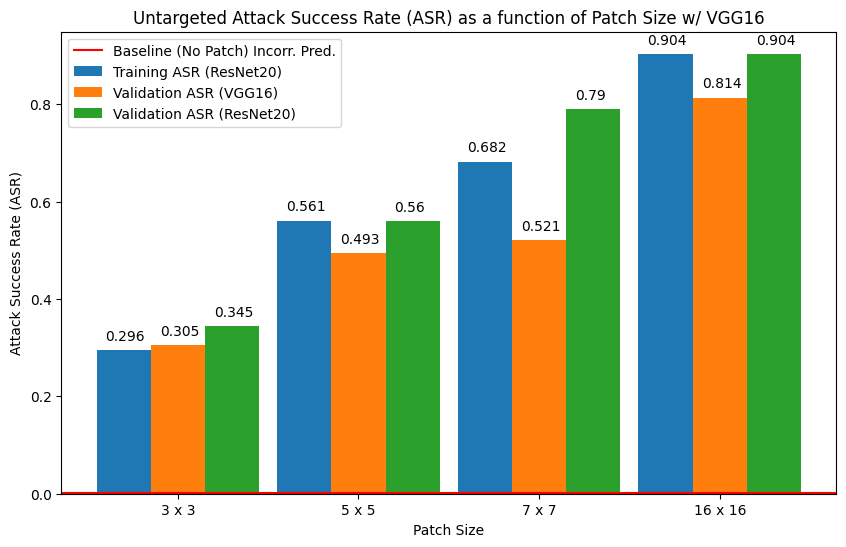

In [80]:
# evaluate for vgg
vgg_model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16_bn') # batch normalized
vgg_model = vgg_model.to(device)
vgg_model.load_state_dict(torch.load("./pretrained_models/pretrained_vgg_model.pt")) # run the vgg.ipynb notebook if you want to generate the .pt file. Too big to upload to github.
plot_asr(patches, results, val_loader, patch_size, attack_type = 'Untargeted', shape = 'square', model = vgg_model, model_name = 'VGG16')

### Transferability - DenseNet

In [ ]:

densenet_model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121')
densenet_model = densenet_model.to(device)
# run the densenet.ipynb notebook if you want to generate the .pt file. Too big to upload to github.
densenet_model.load_state_dict(torch.load("./pretrained_models/pretrained_densenet_model.pt")) 
plot_asr(patches, results, val_loader, patch_size, attack_type = 'Untargeted', shape = 'square', model = densenet_model, model_name = 'DenseNet121')

# Targeted Attack

### Square Patch - Train & Generation

In [83]:
patch_size = ['3 x 3', '5 x 5', '7 x 7', '16 x 16']
classes = ('Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck')

generating patches for class:  Plane


  0%|          | 0/156 [00:00<?, ?it/s]

Epoch 0, Attack Success Rate: 0.0747632309794426.


Epoch 5, Attack Success Rate: 0.9937047362327576.


Epoch 0, Attack Success Rate: 0.06573816388845444.


Epoch 5, Attack Success Rate: 0.4880501329898834.


Epoch 0, Attack Success Rate: 0.07509749382734299.


Epoch 5, Attack Success Rate: 0.13298049569129944.


Epoch 0, Attack Success Rate: 0.06428969651460648.


Epoch 5, Attack Success Rate: 0.09643454104661942.


Test Loss=0.0343, Test accuracy=0.9886


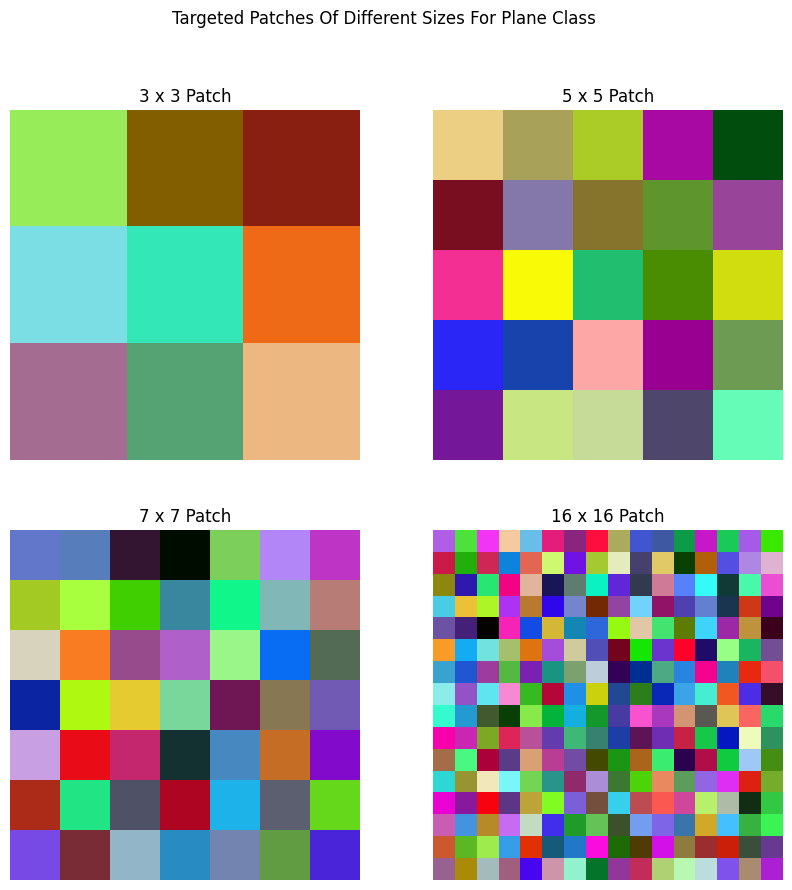

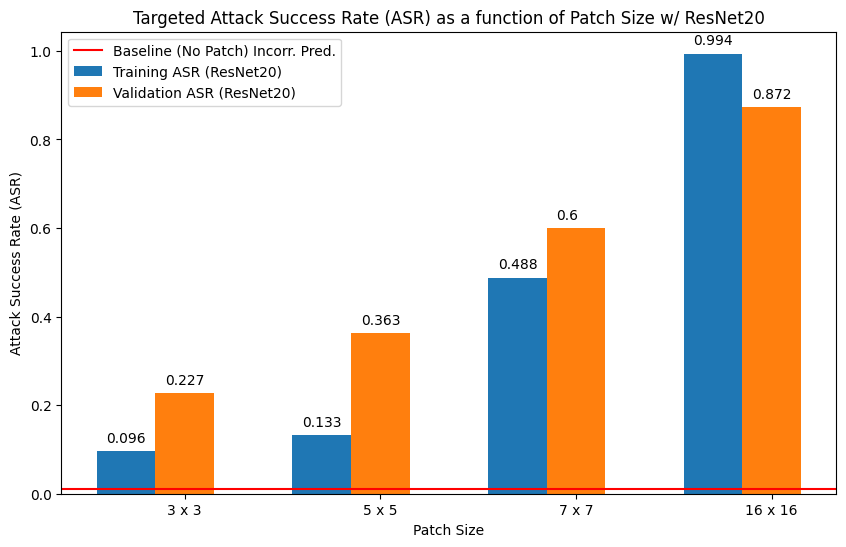

Using cache found in /home/codespace/.cache/torch/hub/pytorch_vision_v0.10.0


Test Loss=0.0127, Test accuracy=0.9992


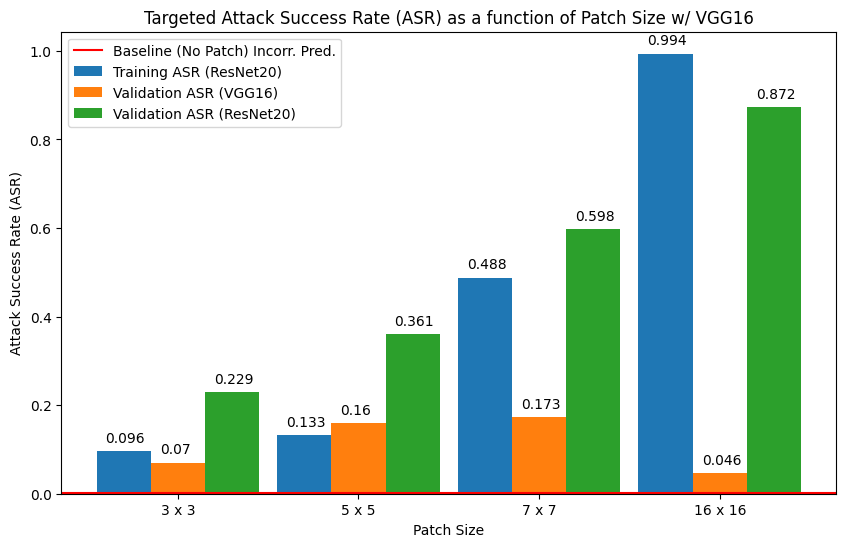

generating patches for class:  Car


Epoch 0, Attack Success Rate: 0.23529087007045746.


Epoch 5, Attack Success Rate: 0.9901846647262573.


Epoch 0, Attack Success Rate: 0.16343176364898682.


Epoch 5, Attack Success Rate: 0.6043463945388794.


Epoch 0, Attack Success Rate: 0.06096549332141876.


Epoch 5, Attack Success Rate: 0.23028643429279327.


Epoch 0, Attack Success Rate: 0.01775049790740013.


Epoch 5, Attack Success Rate: 0.028229374438524246.


Test Loss=0.0343, Test accuracy=0.9886


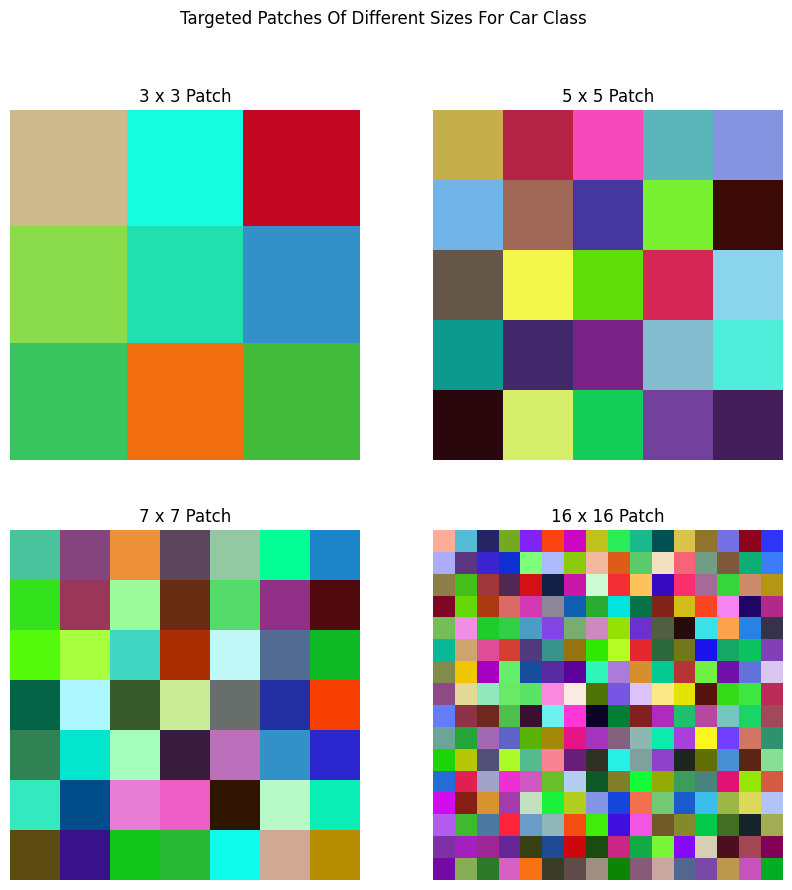

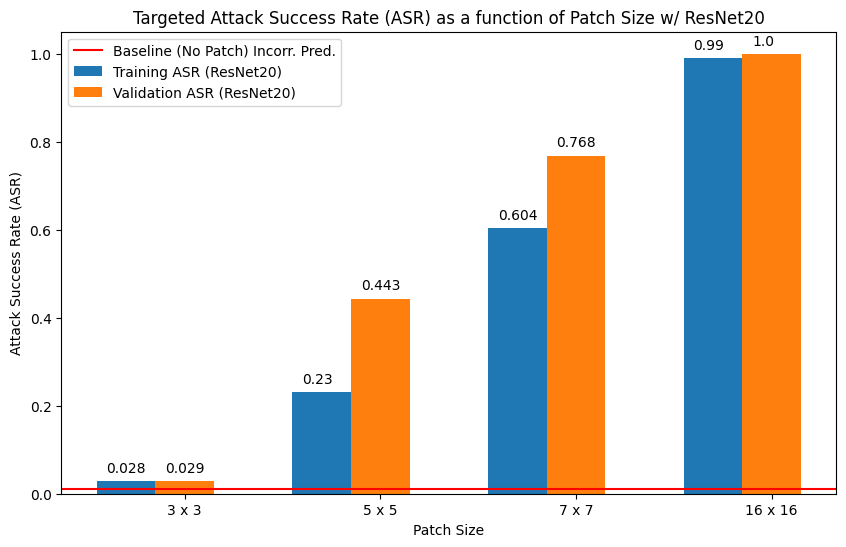

Using cache found in /home/codespace/.cache/torch/hub/pytorch_vision_v0.10.0


Test Loss=0.0127, Test accuracy=0.9992


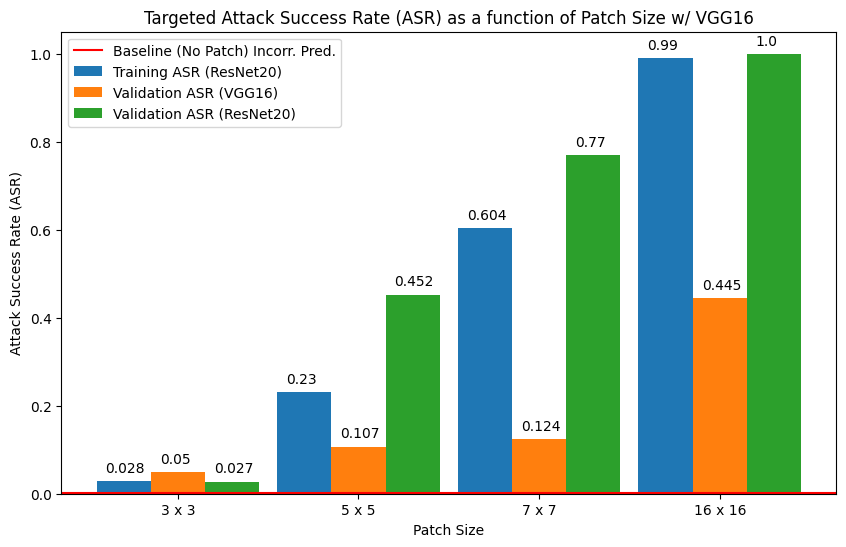

generating patches for class:  Bird


Epoch 0, Attack Success Rate: 0.2135632038116455.


Epoch 5, Attack Success Rate: 0.996032178401947.


Epoch 0, Attack Success Rate: 0.021180283278226852.


Epoch 5, Attack Success Rate: 0.8421258330345154.


Epoch 0, Attack Success Rate: 0.07119704782962799.


Epoch 5, Attack Success Rate: 0.41159048676490784.


Epoch 0, Attack Success Rate: 0.029786519706249237.


Epoch 5, Attack Success Rate: 0.07563988119363785.


Test Loss=0.0343, Test accuracy=0.9886


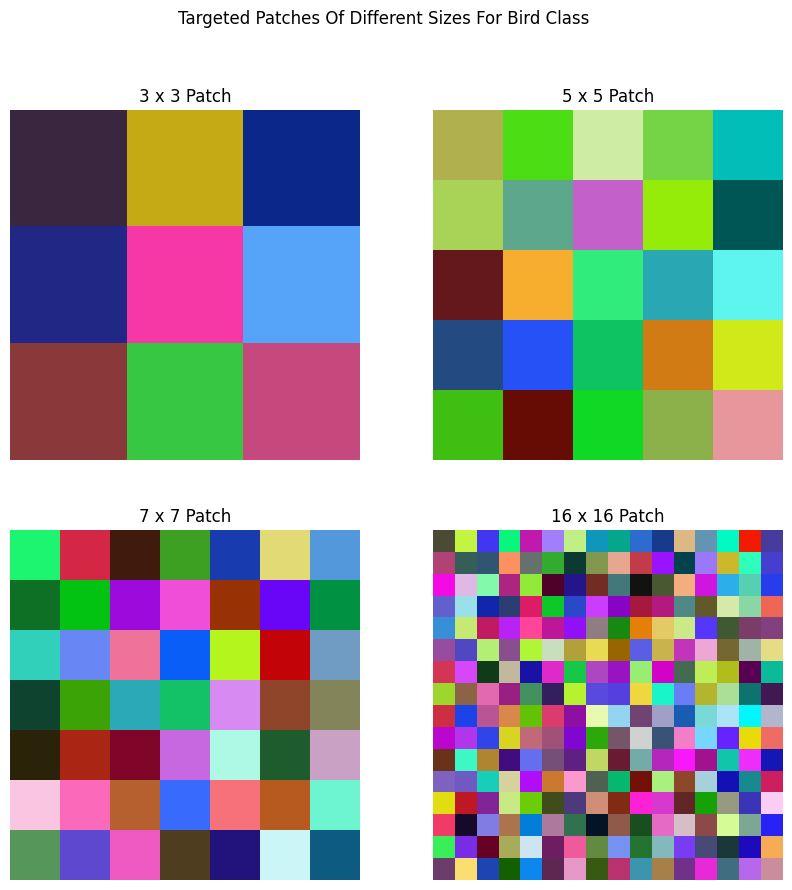

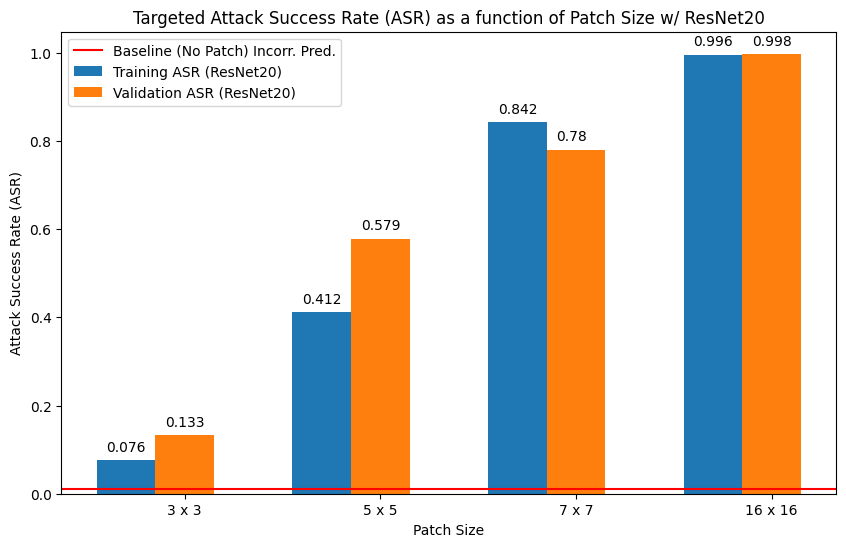

Using cache found in /home/codespace/.cache/torch/hub/pytorch_vision_v0.10.0


Test Loss=0.0127, Test accuracy=0.9992


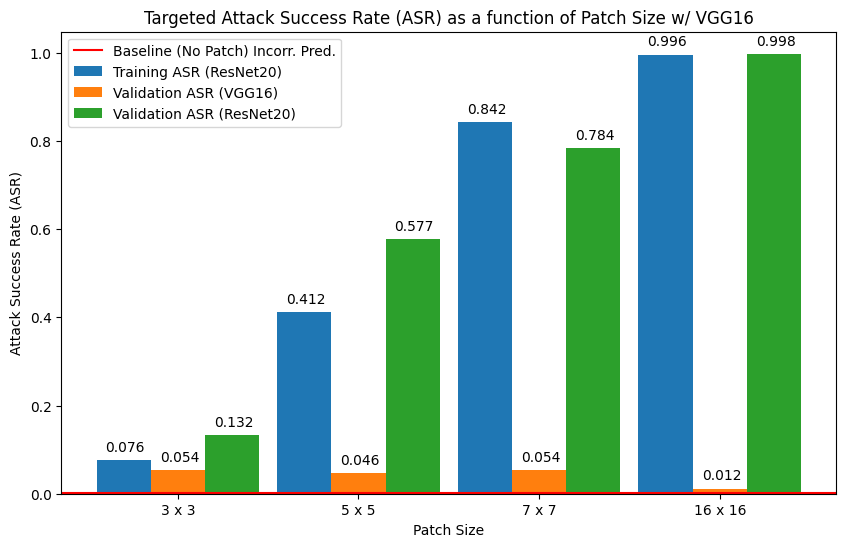

generating patches for class:  Cat


Epoch 0, Attack Success Rate: 0.1167130172252655.


Epoch 5, Attack Success Rate: 0.998108983039856.


Epoch 0, Attack Success Rate: 0.1103726327419281.


Epoch 5, Attack Success Rate: 0.5947719812393188.


Epoch 0, Attack Success Rate: 0.10211346298456192.


Epoch 5, Attack Success Rate: 0.17608453333377838.


Epoch 0, Attack Success Rate: 0.030478309839963913.


Epoch 5, Attack Success Rate: 0.061540599912405014.


Test Loss=0.0343, Test accuracy=0.9886


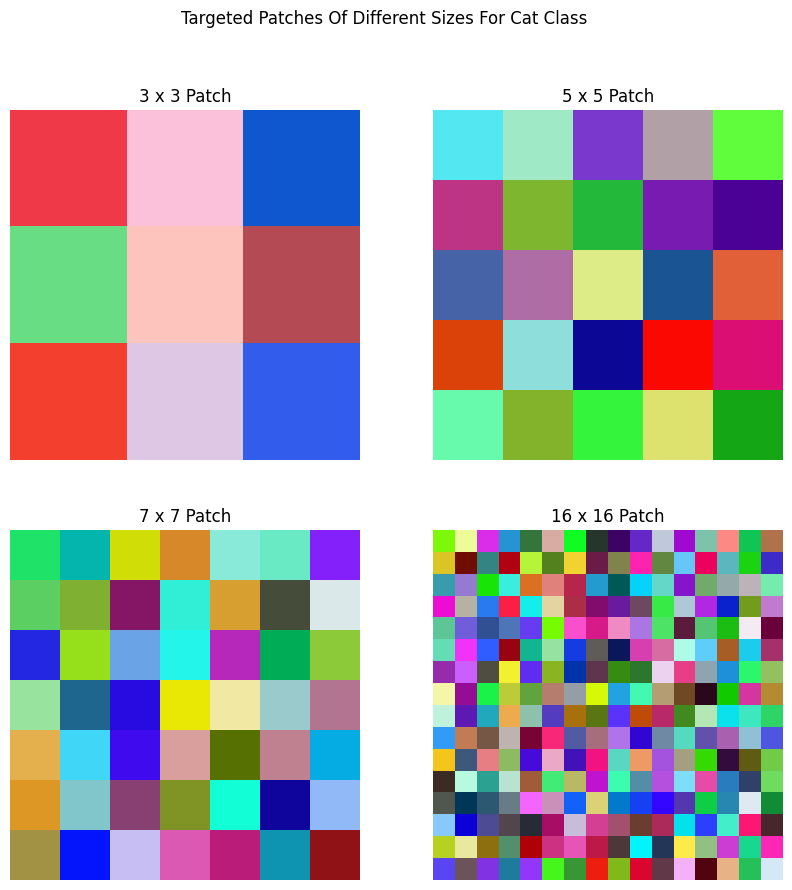

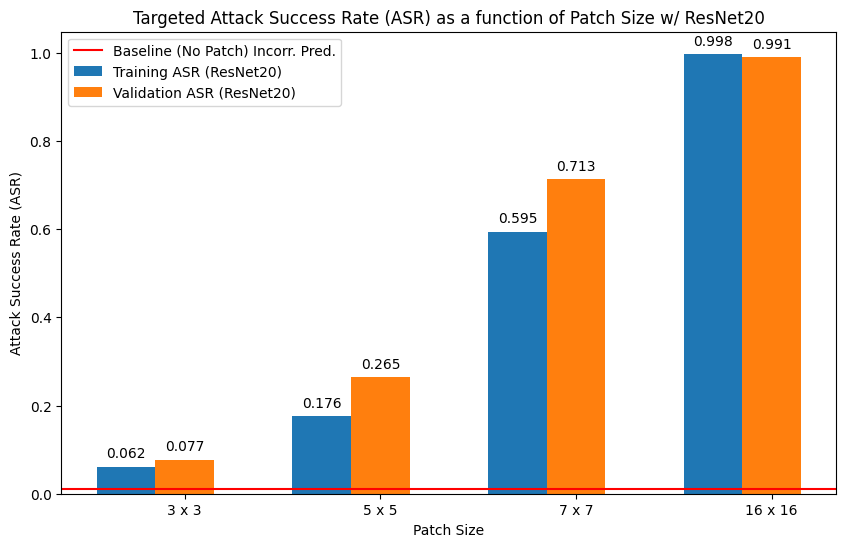

Using cache found in /home/codespace/.cache/torch/hub/pytorch_vision_v0.10.0


Test Loss=0.0127, Test accuracy=0.9992


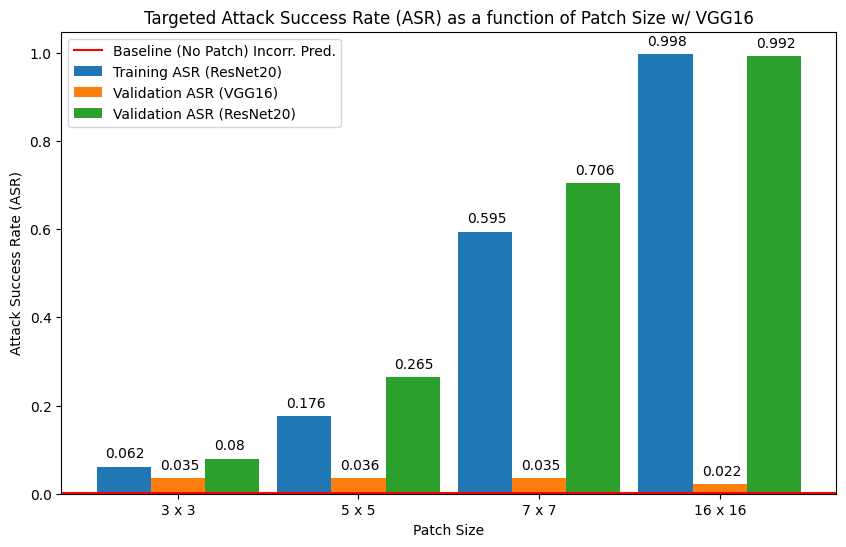

generating patches for class:  Deer


Epoch 0, Attack Success Rate: 0.15004435181617737.


Epoch 5, Attack Success Rate: 0.9994456171989441.


Epoch 0, Attack Success Rate: 0.042521342635154724.


Epoch 5, Attack Success Rate: 0.7009923458099365.


Epoch 0, Attack Success Rate: 0.011808404698967934.


Epoch 5, Attack Success Rate: 0.29648518562316895.


Epoch 0, Attack Success Rate: 0.011669808067381382.


Epoch 5, Attack Success Rate: 0.015495065599679947.


Test Loss=0.0343, Test accuracy=0.9886


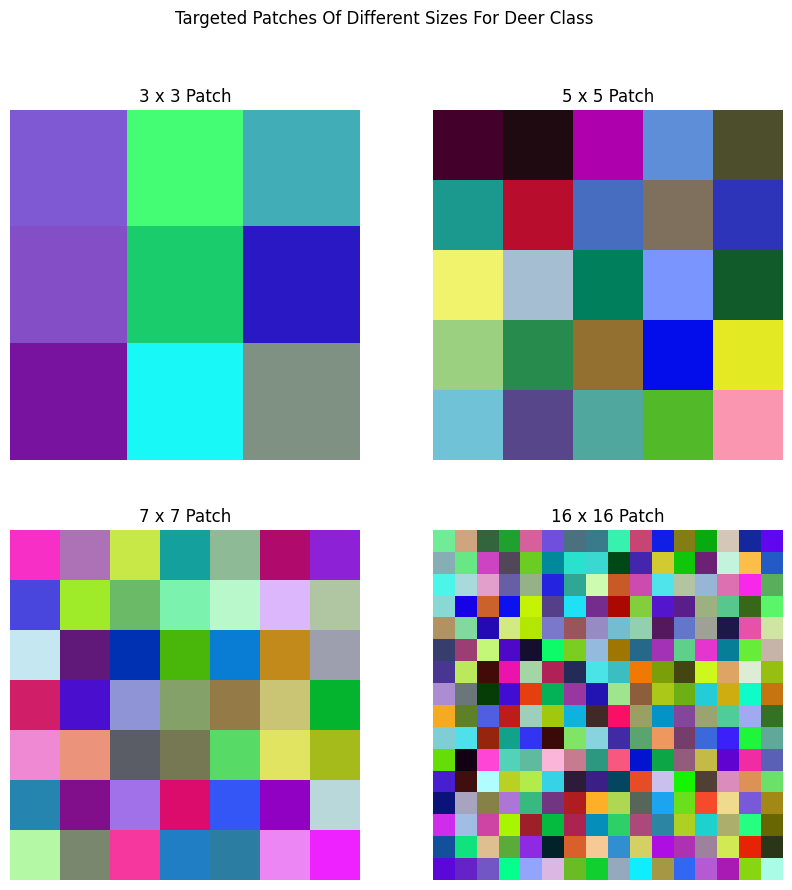

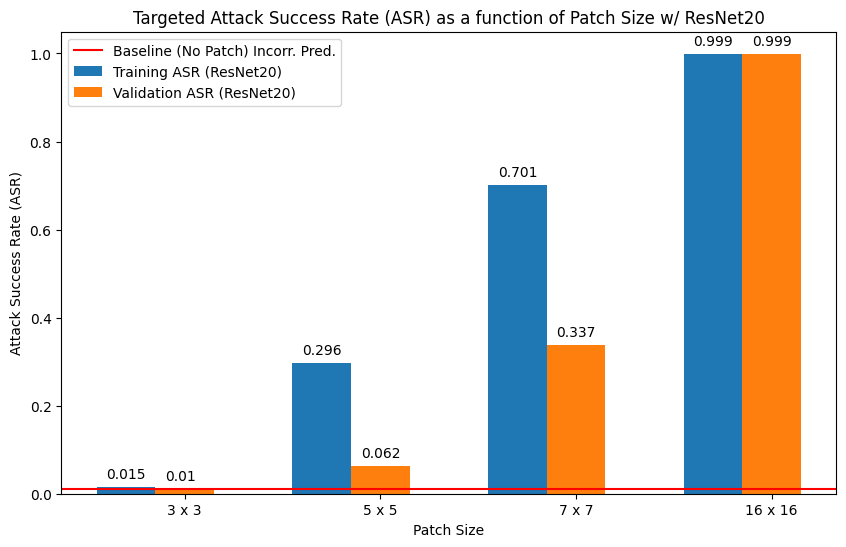

Using cache found in /home/codespace/.cache/torch/hub/pytorch_vision_v0.10.0


Test Loss=0.0127, Test accuracy=0.9992


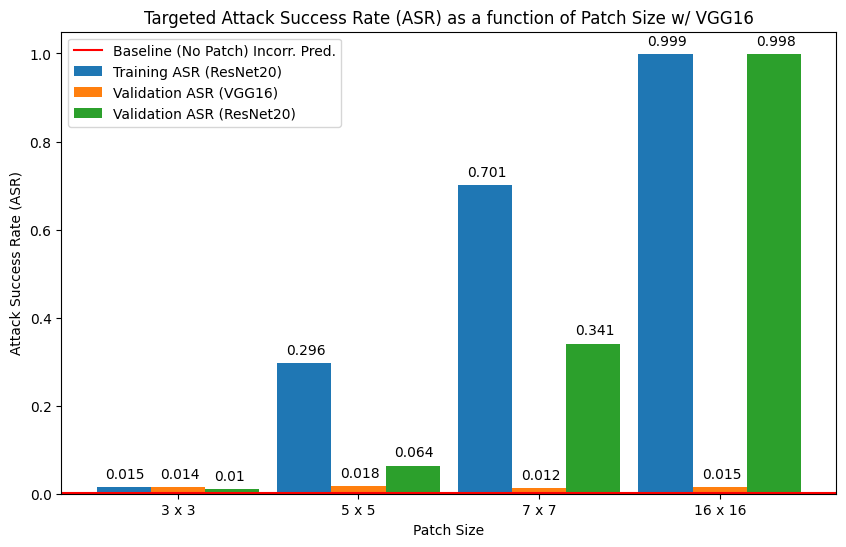

generating patches for class:  Dog


Epoch 0, Attack Success Rate: 0.09886174649000168.


Epoch 5, Attack Success Rate: 0.9995835423469543.


Epoch 0, Attack Success Rate: 0.11191005259752274.


Epoch 5, Attack Success Rate: 0.5842587351799011.


Epoch 0, Attack Success Rate: 0.05688506364822388.


Epoch 5, Attack Success Rate: 0.1782343089580536.


Epoch 0, Attack Success Rate: 0.028928373008966446.


Epoch 5, Attack Success Rate: 0.07518045604228973.


Test Loss=0.0343, Test accuracy=0.9886


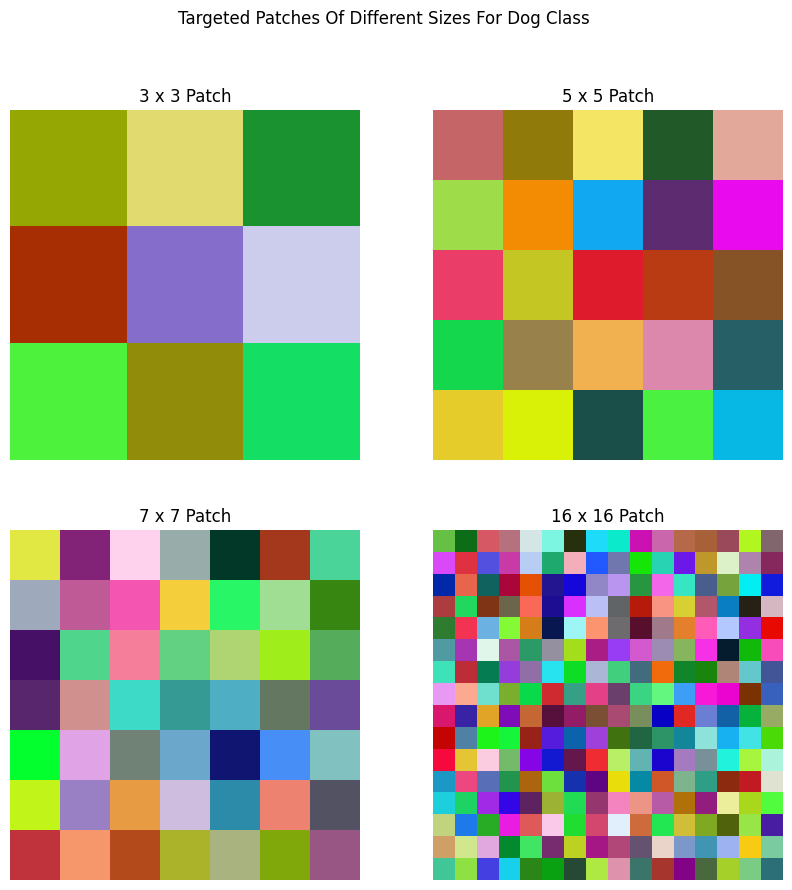

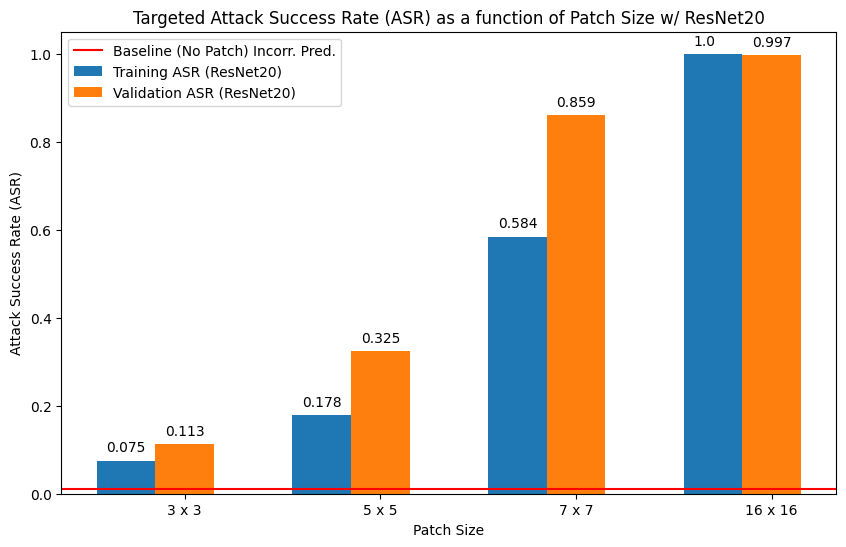

Using cache found in /home/codespace/.cache/torch/hub/pytorch_vision_v0.10.0


Test Loss=0.0127, Test accuracy=0.9992


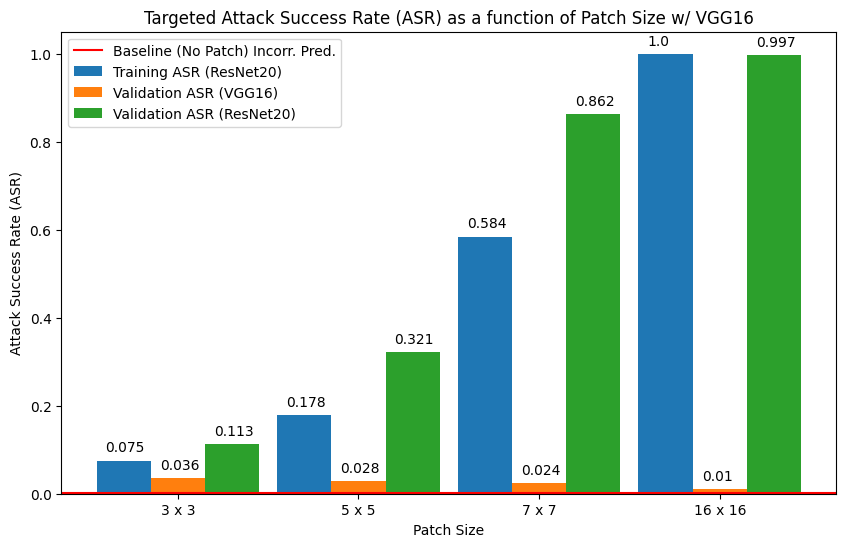

generating patches for class:  Frog


Epoch 0, Attack Success Rate: 0.0800962820649147.


Epoch 5, Attack Success Rate: 0.9977312684059143.


Epoch 0, Attack Success Rate: 0.021165339276194572.


Epoch 5, Attack Success Rate: 0.6789785027503967.


Epoch 0, Attack Success Rate: 0.007746790535748005.


Epoch 5, Attack Success Rate: 0.15250110626220703.


Epoch 0, Attack Success Rate: 0.005007746629416943.


Epoch 5, Attack Success Rate: 0.027888447046279907.


Test Loss=0.0343, Test accuracy=0.9886


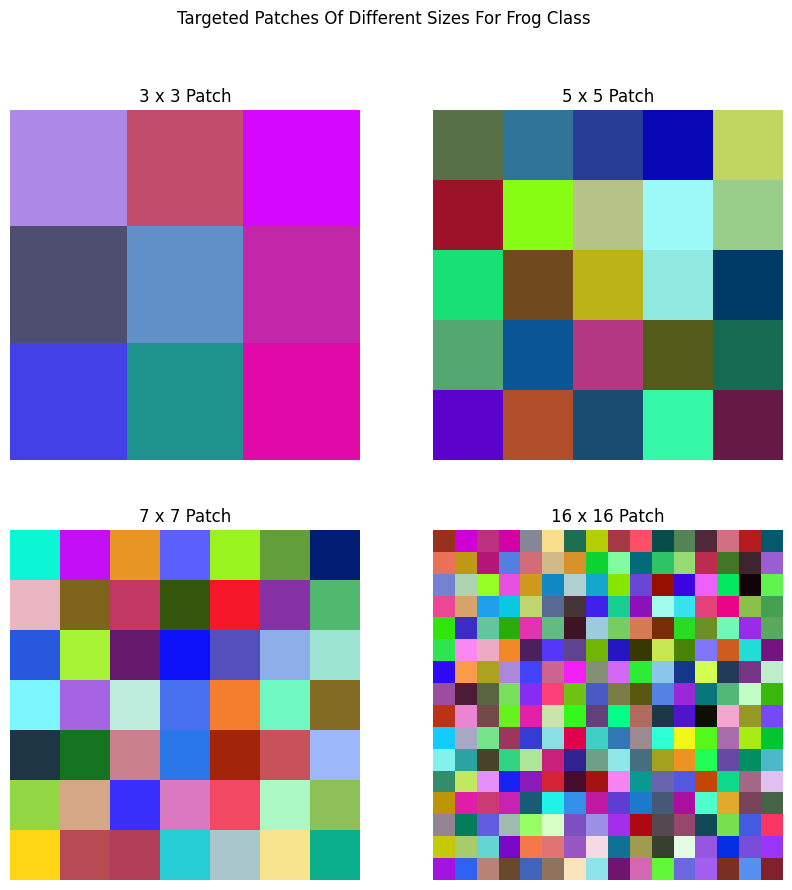

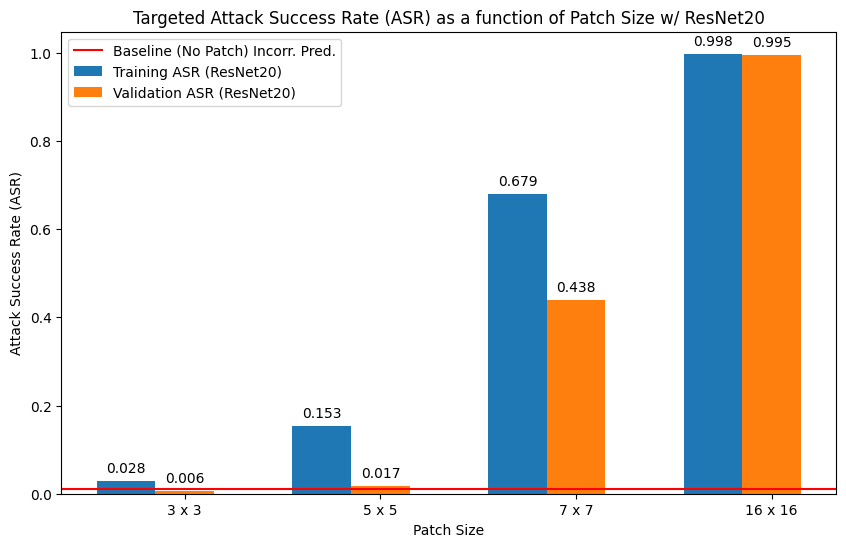

Using cache found in /home/codespace/.cache/torch/hub/pytorch_vision_v0.10.0


Test Loss=0.0127, Test accuracy=0.9992


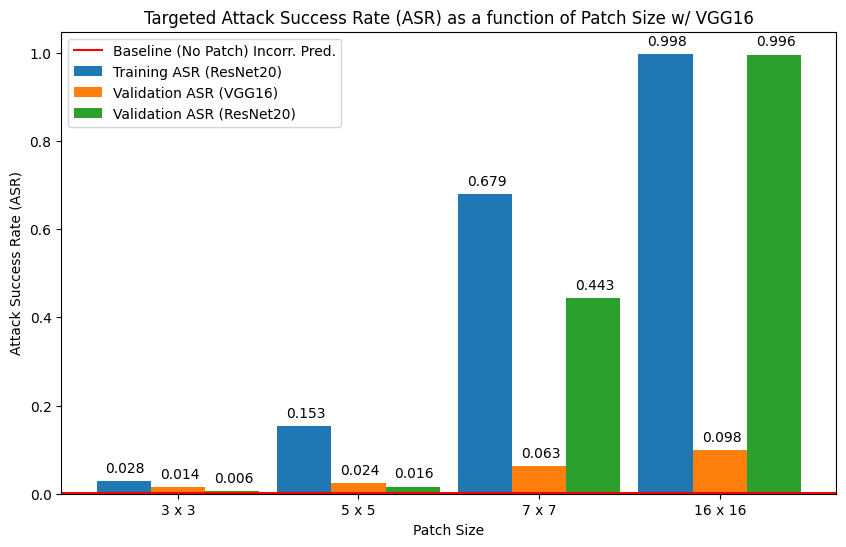

generating patches for class:  Horse


Epoch 0, Attack Success Rate: 0.10426606237888336.


Epoch 5, Attack Success Rate: 0.9963663816452026.


Epoch 0, Attack Success Rate: 0.016004659235477448.


Epoch 5, Attack Success Rate: 0.5970820188522339.


Epoch 0, Attack Success Rate: 0.01694774255156517.


Epoch 5, Attack Success Rate: 0.12251747399568558.


Epoch 0, Attack Success Rate: 0.015671808272600174.


Epoch 5, Attack Success Rate: 0.022883612662553787.


Test Loss=0.0343, Test accuracy=0.9886


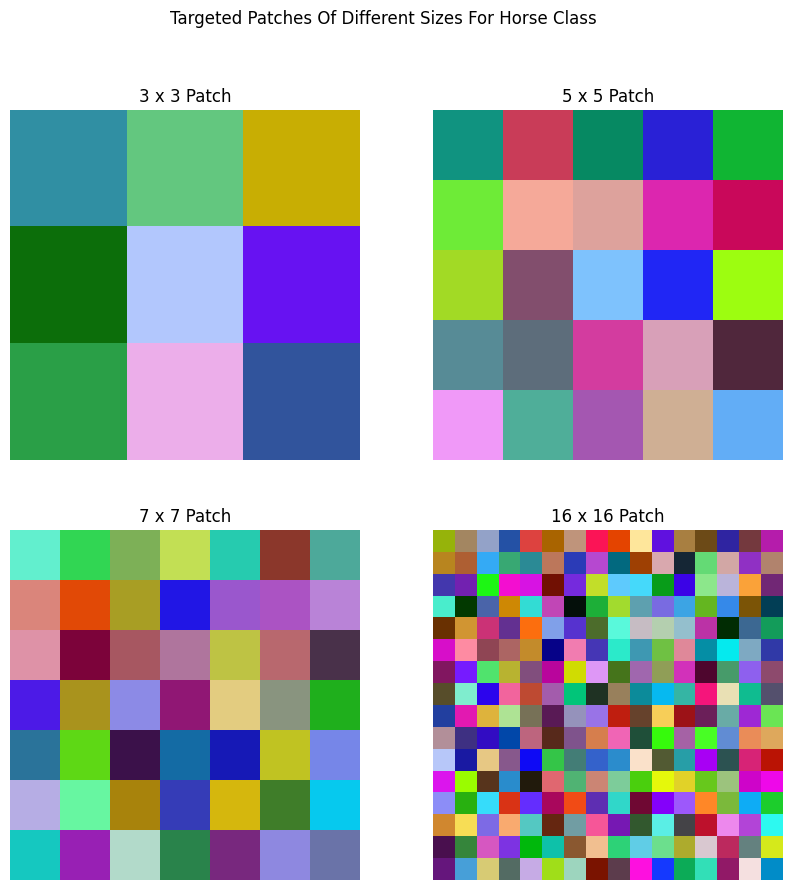

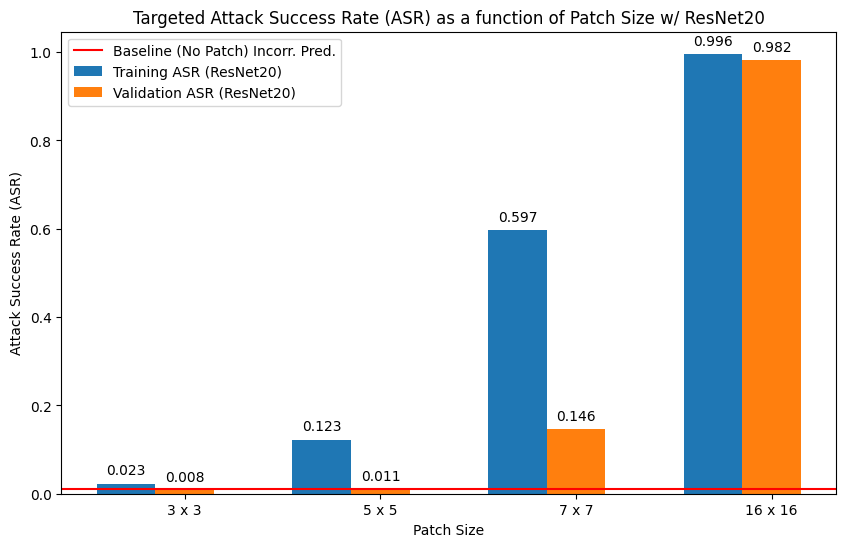

Using cache found in /home/codespace/.cache/torch/hub/pytorch_vision_v0.10.0


Test Loss=0.0127, Test accuracy=0.9992


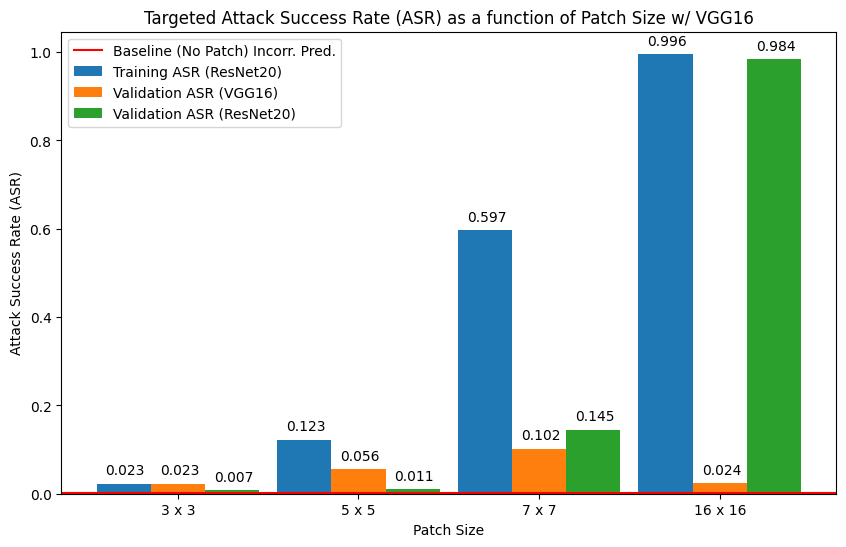

generating patches for class:  Ship


Epoch 0, Attack Success Rate: 0.11322857439517975.


Epoch 5, Attack Success Rate: 0.9781288504600525.


Epoch 0, Attack Success Rate: 0.036916304379701614.


Epoch 5, Attack Success Rate: 0.3301014006137848.


Epoch 0, Attack Success Rate: 0.008525576442480087.


Epoch 5, Attack Success Rate: 0.11852223426103592.


Epoch 0, Attack Success Rate: 0.003928451798856258.


Epoch 5, Attack Success Rate: 0.02382146380841732.


Test Loss=0.0343, Test accuracy=0.9886


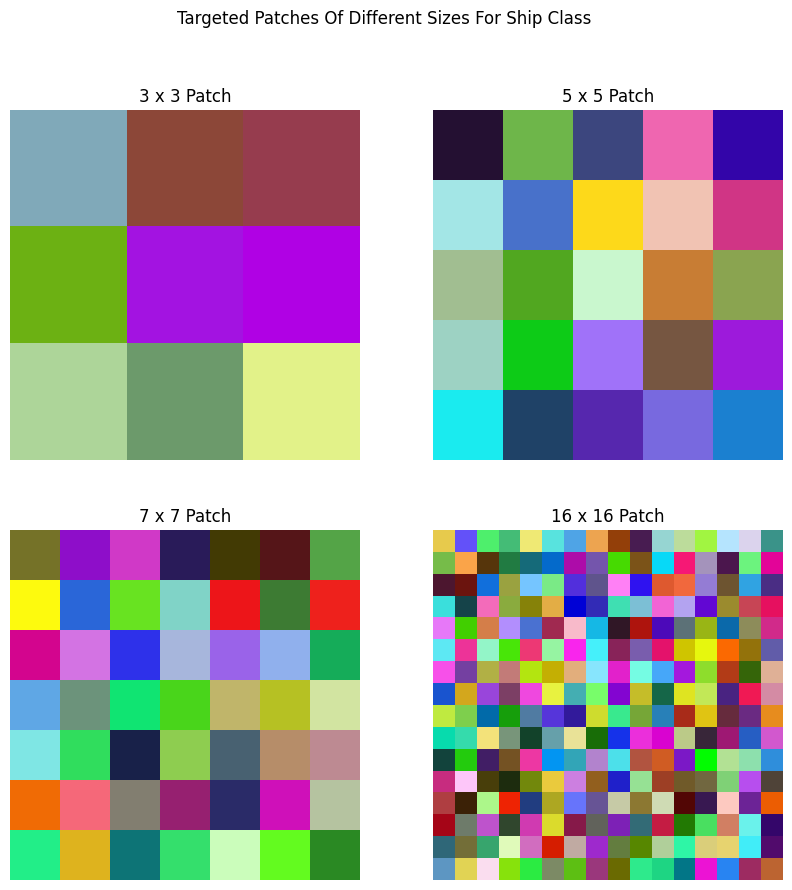

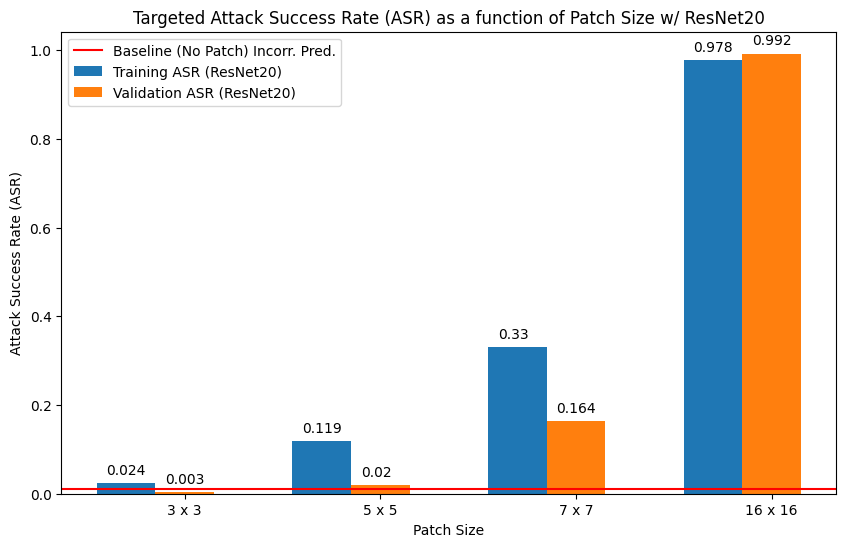

Using cache found in /home/codespace/.cache/torch/hub/pytorch_vision_v0.10.0


Test Loss=0.0127, Test accuracy=0.9992


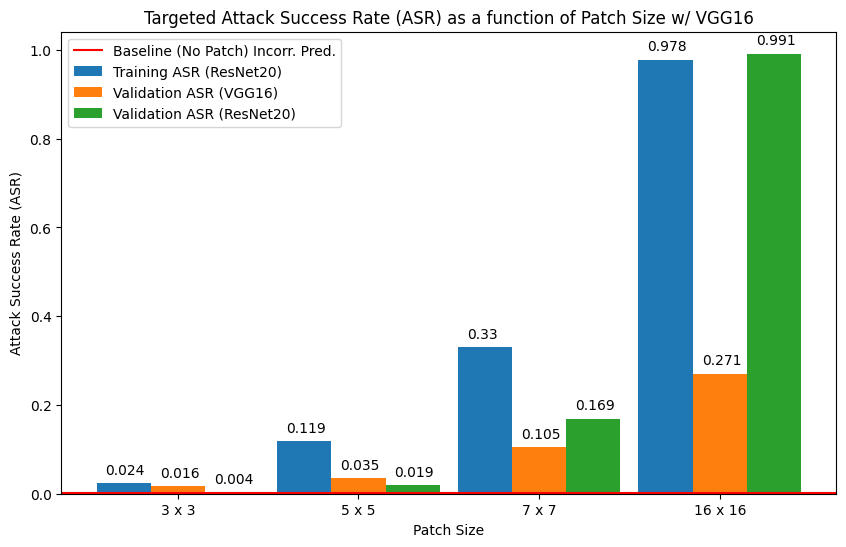

generating patches for class:  Truck


Epoch 0, Attack Success Rate: 0.19733333587646484.


Epoch 5, Attack Success Rate: 0.9838055372238159.


Epoch 0, Attack Success Rate: 0.05047222226858139.


Epoch 5, Attack Success Rate: 0.34372222423553467.


Epoch 0, Attack Success Rate: 0.02036111056804657.


Epoch 5, Attack Success Rate: 0.19394443929195404.


Epoch 0, Attack Success Rate: 0.009166666306555271.


Epoch 5, Attack Success Rate: 0.015472222119569778.


Test Loss=0.0343, Test accuracy=0.9886


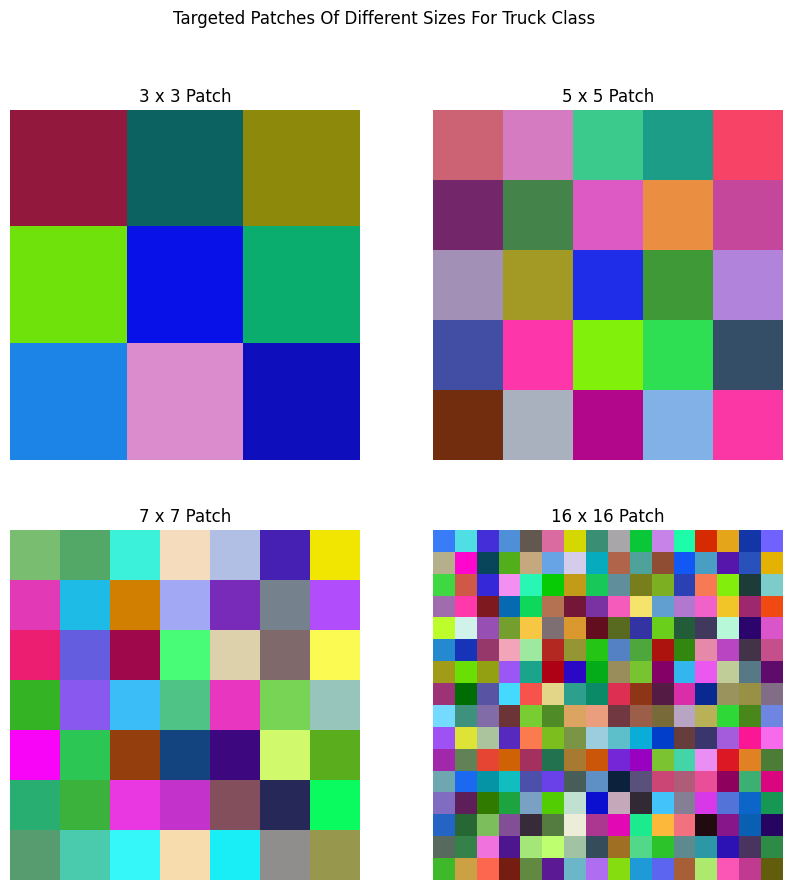

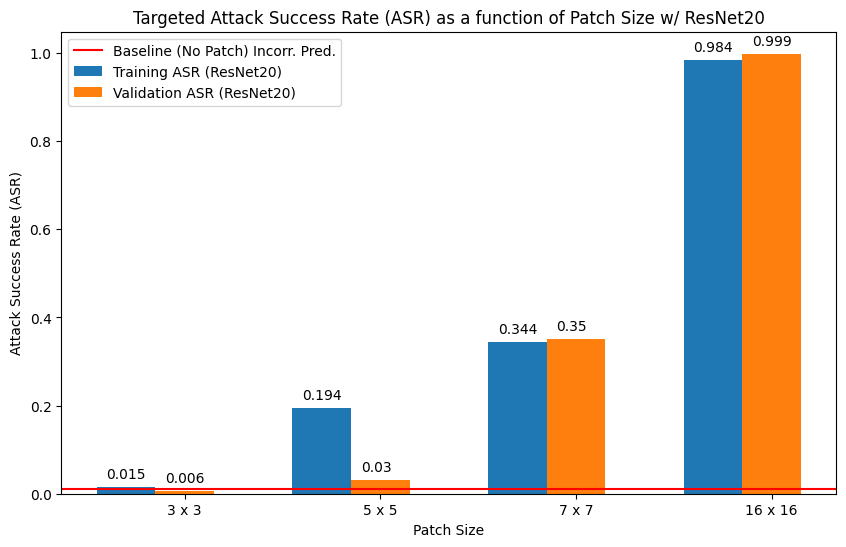

Using cache found in /home/codespace/.cache/torch/hub/pytorch_vision_v0.10.0


Test Loss=0.0127, Test accuracy=0.9992


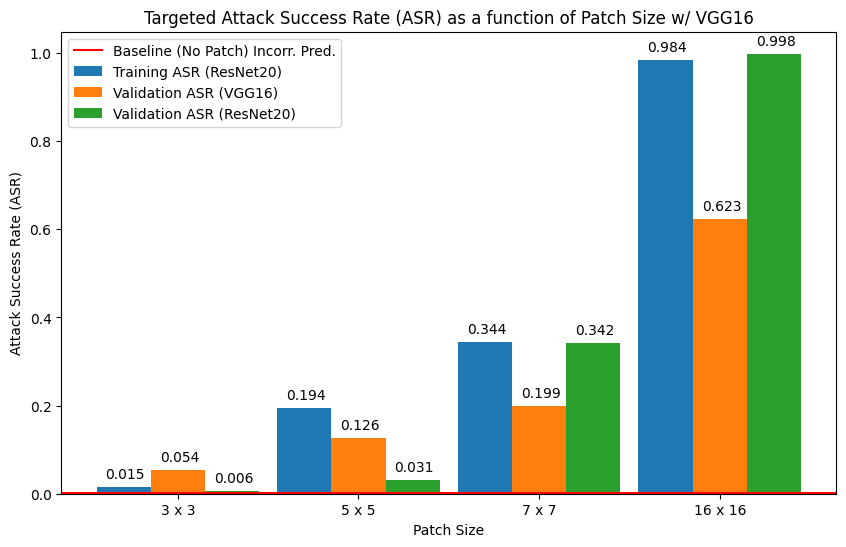

In [84]:
# should take about 200 minutes to run on a GPU

for i in range(len(classes)):
    print("generating patches for class: ", classes[i])
    p_16_t, r_16_t = generate_patch(patch_size = 16, patch_type = 'square', targeted = True, train_loader = train_loader, val_loader = val_loader, target_class = i, device = 'cuda', num_epochs = 10)
    p_7_t, r_7_t = generate_patch(patch_size = 7, patch_type = 'square', targeted = True, train_loader = train_loader, val_loader = val_loader, target_class = i, device = 'cuda', num_epochs = 10)
    p_5_t, r_5_t = generate_patch(patch_size = 5, patch_type = 'square', targeted = True, train_loader = train_loader, val_loader = val_loader, target_class = i, device = 'cuda', num_epochs = 10)
    p_3_t, r_3_t = generate_patch(patch_size = 3, patch_type = 'square', targeted = True, train_loader = train_loader, val_loader = val_loader, target_class = i, device = 'cuda', num_epochs = 10)

    write_to_json(p_3_t, r_3_t, 3, 'Targeted', target = classes[i])
    write_to_json(p_5_t, r_5_t, 5, 'Targeted', target = classes[i])
    write_to_json(p_7_t, r_7_t, 7, 'Targeted', target = classes[i])
    write_to_json(p_16_t, r_16_t, 16, 'Targeted', target = classes[i])

    # evaluation & results generation
    patches = [p_3_t, p_5_t, p_7_t, p_16_t]
    results = [r_3_t, r_5_t, r_7_t, r_16_t]

    plt.figure(figsize=(10, 10))

    for j in range(len(patch_size)):
        plt.subplot(2, 2, j + 1)
        image = transform_image(patches[j])
        plt.imshow(image)
        plt.title(patch_size[j] + " Patch")
        plt.axis("off")

    plt.suptitle(f"Targeted Patches Of Different Sizes For {classes[i]} Class")

    plt.savefig(f"../20_output_files/targeted_patches_{classes[i]}.png")

    plot_asr(patches, results, val_loader, patch_size, target = i, attack_type = 'Targeted', shape = 'square', model_name='ResNet20')

    # transferability to VGG
    # evaluate for vgg
    vgg_model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16_bn') # batch normalized
    vgg_model = vgg_model.to(device)
    vgg_model.load_state_dict(torch.load("./pretrained_models/pretrained_vgg_model.pt")) # run the vgg.ipynb notebook if you want to generate the .pt file. Too big to upload to github.
    plot_asr(patches, results, val_loader, patch_size, target = i, attack_type = 'Targeted', shape = 'square', model = vgg_model,  model_name='VGG16')